# QML Assignment

## Initial notebook

In [30]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-11-30 13:55:41,542: Credentials are already in use. The existing account in the session will be replaced.


In [31]:
from qiskit.ml.datasets import *
from qiskit import QuantumCircuit
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
%matplotlib inline

In [32]:
# size of training data set
training_size = 100
# size of test data set
test_size = 20
# dimension of data sets
n = 2
# construct training and test data
_, training_input, test_input, class_labels = ad_hoc_data(training_size=training_size, test_size=test_size, n=2, gap=0.3, plot_data=False)
print(class_labels)

['A', 'B']


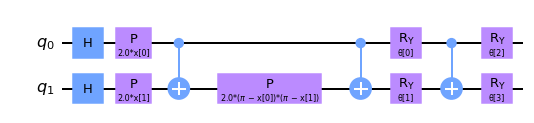

In [33]:
sv = Statevector.from_label('0' * n)
feature_map = ZZFeatureMap(n, reps=1)
var_form = RealAmplitudes(n, reps=1)
circuit = feature_map.combine(var_form)
circuit.decompose().draw(output='mpl')

In [34]:
def get_data_dict(params, x):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = x[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = params[i]
    return parameters

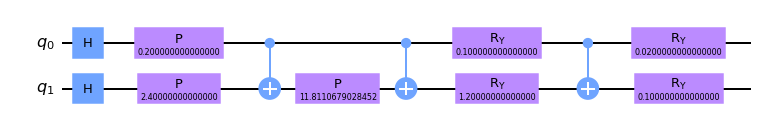

In [35]:
data = [0.1, 1.2]
params = np.array([0.1, 1.2, 0.02, 0.1])
circ_ = circuit.assign_parameters(get_data_dict(params, data))
circ_.decompose().draw(plot_barriers=True)

In [36]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

In [37]:
return_probabilities({'00' : 10, '01': 10, '11': 20}, class_labels)  

{'A': 0.75, 'B': 0.25}

In [38]:
def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circ_ = circuit.assign_parameters(get_data_dict(params, x))
        qc = sv.evolve(circ_)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict() 
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs

In [39]:
# classify a test data point
x = np.asarray([[0.5, 0.9]])
classify(x, params=np.array([0.8, -0.5, 1.5, 0.5]), class_labels=class_labels)

[{'A': 0.9123493926175841, 'B': 0.08765060738241598}]

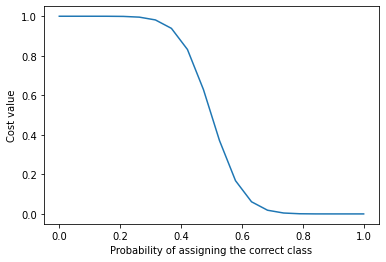

In [40]:
def cost_estimate_sigmoid(probs, expected_label): # probability of labels vs actual labels
    p = probs.get(expected_label)
    sig = None
    if np.isclose(p, 0.0):
        sig = 1
    elif np.isclose(p, 1.0):
        sig = 0
    else:
        denominator = np.sqrt(2*p*(1-p))
        x = np.sqrt(200)*(0.5-p)/denominator
        sig = 1/(1+np.exp(-x))
    return sig
x = np.linspace(0, 1, 20)
y = [cost_estimate_sigmoid({'A': x_, 'B': 1-x_}, 'A') for x_ in x]
plt.plot(x, y)
plt.xlabel('Probability of assigning the correct class')
plt.ylabel('Cost value')
plt.show()

In [41]:
def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]
# classify all samples
    probs = classify(training_samples, params, class_labels)
# evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += cost_estimate_sigmoid(prob, training_labels[i])
    cost /= len(training_samples)
# print resulting objective function
    if print_value:
        print('%.4f' % cost)
# return objective value
    return cost

cost_function(training_input, class_labels, params)

0.42353597584932984

In [42]:
#Train the classifier
#Training the classifier corresponds to an optimisation task. We want to minimize the cost value
#(sigmoid function) such that the classifier manages to properly label the given data.

# setup the optimizer
optimizer = COBYLA(maxiter=100)
# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True) 
# randomly initialize the parameters
np.random.seed(137)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
# print results
print()
print('opt_params:', opt_params)
print('opt_value: ', value)

0.6236
0.5619
0.5878
0.6960
0.3312
0.3154
0.3119
0.3080
0.3129
0.3604
0.2662
0.3147
0.2862
0.2684
0.2588
0.2618
0.2611
0.2553
0.2581
0.2606
0.2439
0.2339
0.2218
0.2093
0.1981
0.1915
0.1874
0.1806
0.2007
0.1797
0.1665
0.1651
0.1635
0.1548
0.1561
0.1504
0.1525
0.1509
0.1486
0.1515
0.1522
0.1478
0.1484
0.1479
0.1478
0.1486
0.1476
0.1480
0.1478
0.1474
0.1476
0.1475
0.1475
0.1474
0.1475
0.1474
0.1474
0.1474
0.1474
0.1473
0.1474
0.1473
0.1473
0.1474
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473

opt_params: [ 7.87470695 -0.0684464   3.95680899  5.56828461]
opt_value:  0.14731461866659007


----------------------------------------------------
Data point:  [0.12566371 2.70176968]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7087417978311958, 'B': 0.29125820216880416}
Classification: CORRECT
----------------------------------------------------
Data point:  [1.25663706 5.2150438 ]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7211294029654666, 'B': 0.27887059703453354}
Classification: CORRECT
----------------------------------------------------
Data point:  [4.71238898 4.52389342]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7022972001045076, 'B': 0.29770279989549253}
Classification: CORRECT
----------------------------------------------------
Data point:  [5.2150438  4.46106157]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7405952749169602, 'B': 0.25940472508303986}
Classification: CORRECT
----------------------------------------------------
Data point:  [4.96371639 1.00530965]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7158422457280199, 'B': 0.2841577542719802}


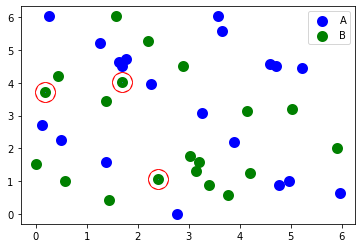

In [43]:
# Test the trained classifier
#To check how well we could train the classifier, we evaluate the classification performance on the
#test data set.
 # collect coordinates of test data
test_label_0_x = [x[0] for x in test_input[class_labels[0]]]
test_label_0_y = [x[1] for x in test_input[class_labels[0]]]
test_label_1_x = [x[0] for x in test_input[class_labels[1]]]
test_label_1_y = [x[1] for x in test_input[class_labels[1]]]
# initialize lists for misclassified datapoints
test_label_misclassified_x = []
test_label_misclassified_y = []
# evaluate test data
for label, samples in test_input.items():
# classify samples
    results = classify(samples, opt_params, class_labels)
# analyze results
    for i, result in enumerate(results):
# assign label
        assigned_label = class_labels[np.argmax([p for p in result.values()])]
        print('----------------------------------------------------')
        print('Data point: ', samples[i])
        print('Label: ', label)
        print('Assigned: ', assigned_label)
        print('Probabilities: ', result)
        if label != assigned_label:
            print('Classification:', 'INCORRECT')
            test_label_misclassified_x += [samples[i][0]]
            test_label_misclassified_y += [samples[i][1]]
        else:
            print('Classification:', 'CORRECT')
# compute fraction of misclassified samples
total = len(test_label_0_x) + len(test_label_1_x)
num_misclassified = len(test_label_misclassified_x)
print()
print(100*(1-num_misclassified/total), "% of the test data was correctly classified!")
# plot results
plt.figure()
plt.scatter(test_label_0_x, test_label_0_y, c='b', label=class_labels[0], linewidths=5)
plt.scatter(test_label_1_x, test_label_1_y, c='g', label=class_labels[1], linewidths=5)
plt.scatter(test_label_misclassified_x, test_label_misclassified_y, linewidths=20, s=1, edgecolors='r')
plt.legend()
plt.show()

## Change feature map: number of repetitions

/opt/conda/lib/python3.8/site-packages/sympy/core/expr.py:2451: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


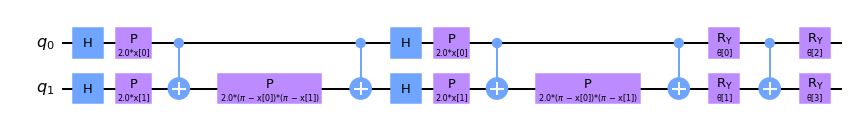

In [44]:
sv = Statevector.from_label('0' * n)
feature_map = ZZFeatureMap(n, reps=2)
var_form = RealAmplitudes(n, reps=1)
circuit = feature_map.combine(var_form)
circuit.decompose().draw(output='mpl')

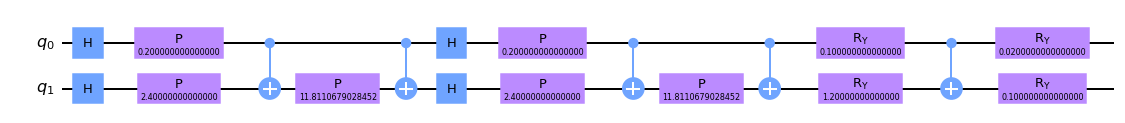

In [45]:
data = [0.1, 1.2]
params = np.array([0.1, 1.2, 0.02, 0.1])
circ_ = circuit.assign_parameters(get_data_dict(params, data))
circ_.decompose().draw(plot_barriers=True)

In [46]:
#Train the classifier
#Training the classifier corresponds to an optimisation task. We want to minimize the cost value
#(sigmoid function) such that the classifier manages to properly label the given data.

# setup the optimizer
optimizer = COBYLA(maxiter=100)
# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True) 
# randomly initialize the parameters
np.random.seed(137)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
# print results
print()
print('opt_params:', opt_params)
print('opt_value: ', value)

0.7242
0.7474
0.7489
0.6484
0.5698
0.4315
0.3908
0.6375
0.3581
0.2453
0.2188
0.2967
0.2107
0.1367
0.1448
0.1711
0.1416
0.1191
0.1412
0.1134
0.1104
0.1073
0.0923
0.0781
0.0696
0.0585
0.0494
0.0514
0.0471
0.0457
0.0420
0.0473
0.0361
0.0325
0.0294
0.0261
0.0238
0.0218
0.0194
0.0174
0.0154
0.0153
0.0156
0.0136
0.0121
0.0111
0.0116
0.0116
0.0106
0.0104
0.0111
0.0098
0.0093
0.0100
0.0092
0.0096
0.0094
0.0094
0.0092
0.0092
0.0091
0.0091
0.0091
0.0092
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091
0.0091

opt_params: [6.9268713  1.63292422 6.35885911 5.51239111]
opt_value:  0.009084652242169977


----------------------------------------------------
Data point:  [0.12566371 2.70176968]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7248599950693579, 'B': 0.275140004930642}
Classification: CORRECT
----------------------------------------------------
Data point:  [1.25663706 5.2150438 ]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.6646359492903603, 'B': 0.33536405070963965}
Classification: CORRECT
----------------------------------------------------
Data point:  [4.71238898 4.52389342]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.8327781109590902, 'B': 0.16722188904090984}
Classification: CORRECT
----------------------------------------------------
Data point:  [5.2150438  4.46106157]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.8797523208986922, 'B': 0.12024767910130776}
Classification: CORRECT
----------------------------------------------------
Data point:  [4.96371639 1.00530965]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.9154775273888266, 'B': 0.08452247261117349}
C

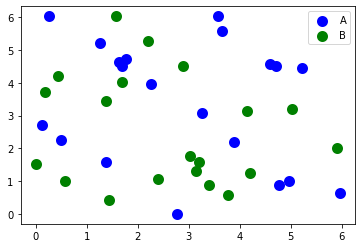

In [47]:
# Test the trained classifier
#To check how well we could train the classifier, we evaluate the classification performance on the
#test data set.
 # collect coordinates of test data
test_label_0_x = [x[0] for x in test_input[class_labels[0]]]
test_label_0_y = [x[1] for x in test_input[class_labels[0]]]
test_label_1_x = [x[0] for x in test_input[class_labels[1]]]
test_label_1_y = [x[1] for x in test_input[class_labels[1]]]
# initialize lists for misclassified datapoints
test_label_misclassified_x = []
test_label_misclassified_y = []
# evaluate test data
for label, samples in test_input.items():
# classify samples
    results = classify(samples, opt_params, class_labels)
# analyze results
    for i, result in enumerate(results):
# assign label
        assigned_label = class_labels[np.argmax([p for p in result.values()])]
        print('----------------------------------------------------')
        print('Data point: ', samples[i])
        print('Label: ', label)
        print('Assigned: ', assigned_label)
        print('Probabilities: ', result)
        if label != assigned_label:
            print('Classification:', 'INCORRECT')
            test_label_misclassified_x += [samples[i][0]]
            test_label_misclassified_y += [samples[i][1]]
        else:
            print('Classification:', 'CORRECT')
# compute fraction of misclassified samples
total = len(test_label_0_x) + len(test_label_1_x)
num_misclassified = len(test_label_misclassified_x)
print()
print(100*(1-num_misclassified/total), "% of the test data was correctly classified!")
# plot results
plt.figure()
plt.scatter(test_label_0_x, test_label_0_y, c='b', label=class_labels[0], linewidths=5)
plt.scatter(test_label_1_x, test_label_1_y, c='g', label=class_labels[1], linewidths=5)
plt.scatter(test_label_misclassified_x, test_label_misclassified_y, linewidths=20, s=1, edgecolors='r')
plt.legend()
plt.show()

## Change feature map: ZFeatureMap

In [48]:
from qiskit.circuit.library import ZFeatureMap

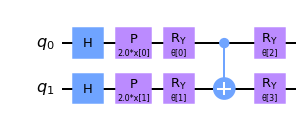

In [49]:
sv = Statevector.from_label('0' * n)
feature_map = ZFeatureMap(n, reps=1)
var_form = RealAmplitudes(n, reps=1)
circuit = feature_map.combine(var_form)
circuit.decompose().draw(output='mpl')

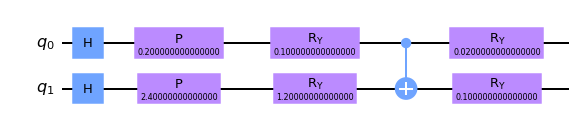

In [50]:
data = [0.1, 1.2]
params = np.array([0.1, 1.2, 0.02, 0.1])
circ_ = circuit.assign_parameters(get_data_dict(params, data))
circ_.decompose().draw(plot_barriers=True)

In [51]:
#Train the classifier
#Training the classifier corresponds to an optimisation task. We want to minimize the cost value
#(sigmoid function) such that the classifier manages to properly label the given data.

# setup the optimizer
optimizer = COBYLA(maxiter=100)
# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True) 
# randomly initialize the parameters
np.random.seed(137)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
# print results
print()
print('opt_params:', opt_params)
print('opt_value: ', value)

0.5688
0.5693
0.5684
0.5672
0.4302
0.3512
0.4458
0.3528
0.2982
0.3403
0.3999
0.2742
0.2966
0.2761
0.3409
0.2991
0.2735
0.2744
0.2748
0.2729
0.2734
0.2694
0.2707
0.2701
0.2694
0.2698
0.2709
0.2684
0.2681
0.2680
0.2681
0.2679
0.2684
0.2680
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2679
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2678
0.2677
0.2677
0.2677

opt_params: [5.83994455 2.69155058 4.61035992 6.24272585]
opt_value:  0.26773849885238316


----------------------------------------------------
Data point:  [0.12566371 2.70176968]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.6274374570250597, 'B': 0.3725625429749404}
Classification: CORRECT
----------------------------------------------------
Data point:  [1.25663706 5.2150438 ]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7204298750874447, 'B': 0.2795701249125553}
Classification: CORRECT
----------------------------------------------------
Data point:  [4.71238898 4.52389342]
Label:  A
Assigned:  B
Probabilities:  {'A': 0.46198424033750934, 'B': 0.5380157596624907}
Classification: INCORRECT
----------------------------------------------------
Data point:  [5.2150438  4.46106157]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.6733937845137139, 'B': 0.32660621548628616}
Classification: CORRECT
----------------------------------------------------
Data point:  [4.96371639 1.00530965]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.6915864596854171, 'B': 0.308413540314583}
C

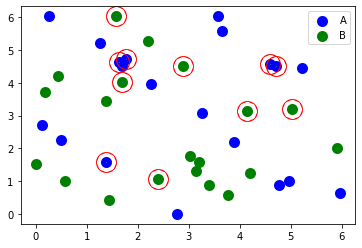

In [52]:
# Test the trained classifier
#To check how well we could train the classifier, we evaluate the classification performance on the
#test data set.
 # collect coordinates of test data
test_label_0_x = [x[0] for x in test_input[class_labels[0]]]
test_label_0_y = [x[1] for x in test_input[class_labels[0]]]
test_label_1_x = [x[0] for x in test_input[class_labels[1]]]
test_label_1_y = [x[1] for x in test_input[class_labels[1]]]
# initialize lists for misclassified datapoints
test_label_misclassified_x = []
test_label_misclassified_y = []
# evaluate test data
for label, samples in test_input.items():
# classify samples
    results = classify(samples, opt_params, class_labels)
# analyze results
    for i, result in enumerate(results):
# assign label
        assigned_label = class_labels[np.argmax([p for p in result.values()])]
        print('----------------------------------------------------')
        print('Data point: ', samples[i])
        print('Label: ', label)
        print('Assigned: ', assigned_label)
        print('Probabilities: ', result)
        if label != assigned_label:
            print('Classification:', 'INCORRECT')
            test_label_misclassified_x += [samples[i][0]]
            test_label_misclassified_y += [samples[i][1]]
        else:
            print('Classification:', 'CORRECT')
# compute fraction of misclassified samples
total = len(test_label_0_x) + len(test_label_1_x)
num_misclassified = len(test_label_misclassified_x)
print()
print(100*(1-num_misclassified/total), "% of the test data was correctly classified!")
# plot results
plt.figure()
plt.scatter(test_label_0_x, test_label_0_y, c='b', label=class_labels[0], linewidths=5)
plt.scatter(test_label_1_x, test_label_1_y, c='g', label=class_labels[1], linewidths=5)
plt.scatter(test_label_misclassified_x, test_label_misclassified_y, linewidths=20, s=1, edgecolors='r')
plt.legend()
plt.show()

## Change feature map: linear entanglement

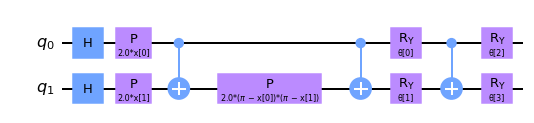

In [53]:
sv = Statevector.from_label('0' * n)
feature_map = ZZFeatureMap(n, entanglement="linear", reps=1)
var_form = RealAmplitudes(n, reps=1)
circuit = feature_map.combine(var_form)
circuit.decompose().draw(output='mpl')

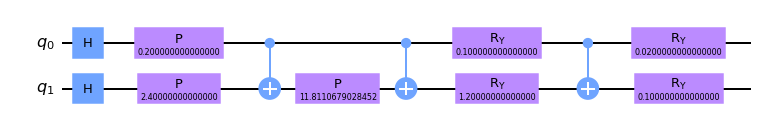

In [54]:
data = [0.1, 1.2]
params = np.array([0.1, 1.2, 0.02, 0.1])
circ_ = circuit.assign_parameters(get_data_dict(params, data))
circ_.decompose().draw(plot_barriers=True)

In [55]:
#Train the classifier
#Training the classifier corresponds to an optimisation task. We want to minimize the cost value
#(sigmoid function) such that the classifier manages to properly label the given data.

# setup the optimizer
optimizer = COBYLA(maxiter=100)
# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True) 
# randomly initialize the parameters
np.random.seed(137)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
# print results
print()
print('opt_params:', opt_params)
print('opt_value: ', value)

0.6236
0.5619
0.5878
0.6960
0.3312
0.3154
0.3119
0.3080
0.3129
0.3604
0.2662
0.3147
0.2862
0.2684
0.2588
0.2618
0.2611
0.2553
0.2581
0.2606
0.2439
0.2339
0.2218
0.2093
0.1981
0.1915
0.1874
0.1806
0.2007
0.1797
0.1665
0.1651
0.1635
0.1548
0.1561
0.1504
0.1525
0.1509
0.1486
0.1515
0.1522
0.1478
0.1484
0.1479
0.1478
0.1486
0.1476
0.1480
0.1478
0.1474
0.1476
0.1475
0.1475
0.1474
0.1475
0.1474
0.1474
0.1474
0.1474
0.1473
0.1474
0.1473
0.1473
0.1474
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473

opt_params: [ 7.87470695 -0.0684464   3.95680899  5.56828461]
opt_value:  0.14731461866659007


----------------------------------------------------
Data point:  [0.12566371 2.70176968]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7087417978311958, 'B': 0.29125820216880416}
Classification: CORRECT
----------------------------------------------------
Data point:  [1.25663706 5.2150438 ]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7211294029654666, 'B': 0.27887059703453354}
Classification: CORRECT
----------------------------------------------------
Data point:  [4.71238898 4.52389342]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7022972001045076, 'B': 0.29770279989549253}
Classification: CORRECT
----------------------------------------------------
Data point:  [5.2150438  4.46106157]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7405952749169602, 'B': 0.25940472508303986}
Classification: CORRECT
----------------------------------------------------
Data point:  [4.96371639 1.00530965]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7158422457280199, 'B': 0.2841577542719802}


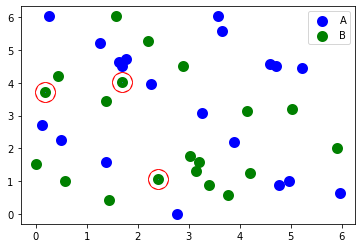

In [56]:
# Test the trained classifier
#To check how well we could train the classifier, we evaluate the classification performance on the
#test data set.
 # collect coordinates of test data
test_label_0_x = [x[0] for x in test_input[class_labels[0]]]
test_label_0_y = [x[1] for x in test_input[class_labels[0]]]
test_label_1_x = [x[0] for x in test_input[class_labels[1]]]
test_label_1_y = [x[1] for x in test_input[class_labels[1]]]
# initialize lists for misclassified datapoints
test_label_misclassified_x = []
test_label_misclassified_y = []
# evaluate test data
for label, samples in test_input.items():
# classify samples
    results = classify(samples, opt_params, class_labels)
# analyze results
    for i, result in enumerate(results):
# assign label
        assigned_label = class_labels[np.argmax([p for p in result.values()])]
        print('----------------------------------------------------')
        print('Data point: ', samples[i])
        print('Label: ', label)
        print('Assigned: ', assigned_label)
        print('Probabilities: ', result)
        if label != assigned_label:
            print('Classification:', 'INCORRECT')
            test_label_misclassified_x += [samples[i][0]]
            test_label_misclassified_y += [samples[i][1]]
        else:
            print('Classification:', 'CORRECT')
# compute fraction of misclassified samples
total = len(test_label_0_x) + len(test_label_1_x)
num_misclassified = len(test_label_misclassified_x)
print()
print(100*(1-num_misclassified/total), "% of the test data was correctly classified!")
# plot results
plt.figure()
plt.scatter(test_label_0_x, test_label_0_y, c='b', label=class_labels[0], linewidths=5)
plt.scatter(test_label_1_x, test_label_1_y, c='g', label=class_labels[1], linewidths=5)
plt.scatter(test_label_misclassified_x, test_label_misclassified_y, linewidths=20, s=1, edgecolors='r')
plt.legend()
plt.show()

## Change ver circuit: linear entanglement

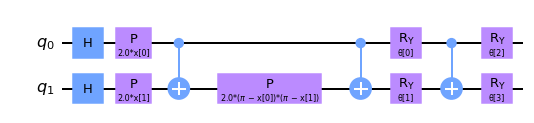

In [57]:
sv = Statevector.from_label('0' * n)
feature_map = ZZFeatureMap(n, reps=1)
var_form = RealAmplitudes(n, entanglement="linear", reps=1)
circuit = feature_map.combine(var_form)
circuit.decompose().draw(output='mpl')

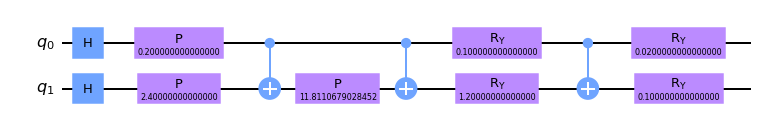

In [58]:
data = [0.1, 1.2]
params = np.array([0.1, 1.2, 0.02, 0.1])
circ_ = circuit.assign_parameters(get_data_dict(params, data))
circ_.decompose().draw(plot_barriers=True)

In [59]:
#Train the classifier
#Training the classifier corresponds to an optimisation task. We want to minimize the cost value
#(sigmoid function) such that the classifier manages to properly label the given data.

# setup the optimizer
optimizer = COBYLA(maxiter=100)
# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True) 
# randomly initialize the parameters
np.random.seed(137)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
# print results
print()
print('opt_params:', opt_params)
print('opt_value: ', value)

0.6236
0.5619
0.5878
0.6960
0.3312
0.3154
0.3119
0.3080
0.3129
0.3604
0.2662
0.3147
0.2862
0.2684
0.2588
0.2618
0.2611
0.2553
0.2581
0.2606
0.2439
0.2339
0.2218
0.2093
0.1981
0.1915
0.1874
0.1806
0.2007
0.1797
0.1665
0.1651
0.1635
0.1548
0.1561
0.1504
0.1525
0.1509
0.1486
0.1515
0.1522
0.1478
0.1484
0.1479
0.1478
0.1486
0.1476
0.1480
0.1478
0.1474
0.1476
0.1475
0.1475
0.1474
0.1475
0.1474
0.1474
0.1474
0.1474
0.1473
0.1474
0.1473
0.1473
0.1474
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473
0.1473

opt_params: [ 7.87470695 -0.0684464   3.95680899  5.56828461]
opt_value:  0.14731461866659007


----------------------------------------------------
Data point:  [0.12566371 2.70176968]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7087417978311958, 'B': 0.29125820216880416}
Classification: CORRECT
----------------------------------------------------
Data point:  [1.25663706 5.2150438 ]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7211294029654666, 'B': 0.27887059703453354}
Classification: CORRECT
----------------------------------------------------
Data point:  [4.71238898 4.52389342]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7022972001045076, 'B': 0.29770279989549253}
Classification: CORRECT
----------------------------------------------------
Data point:  [5.2150438  4.46106157]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7405952749169602, 'B': 0.25940472508303986}
Classification: CORRECT
----------------------------------------------------
Data point:  [4.96371639 1.00530965]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7158422457280199, 'B': 0.2841577542719802}


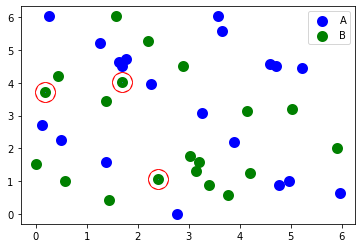

In [60]:
# Test the trained classifier
#To check how well we could train the classifier, we evaluate the classification performance on the
#test data set.
 # collect coordinates of test data
test_label_0_x = [x[0] for x in test_input[class_labels[0]]]
test_label_0_y = [x[1] for x in test_input[class_labels[0]]]
test_label_1_x = [x[0] for x in test_input[class_labels[1]]]
test_label_1_y = [x[1] for x in test_input[class_labels[1]]]
# initialize lists for misclassified datapoints
test_label_misclassified_x = []
test_label_misclassified_y = []
# evaluate test data
for label, samples in test_input.items():
# classify samples
    results = classify(samples, opt_params, class_labels)
# analyze results
    for i, result in enumerate(results):
# assign label
        assigned_label = class_labels[np.argmax([p for p in result.values()])]
        print('----------------------------------------------------')
        print('Data point: ', samples[i])
        print('Label: ', label)
        print('Assigned: ', assigned_label)
        print('Probabilities: ', result)
        if label != assigned_label:
            print('Classification:', 'INCORRECT')
            test_label_misclassified_x += [samples[i][0]]
            test_label_misclassified_y += [samples[i][1]]
        else:
            print('Classification:', 'CORRECT')
# compute fraction of misclassified samples
total = len(test_label_0_x) + len(test_label_1_x)
num_misclassified = len(test_label_misclassified_x)
print()
print(100*(1-num_misclassified/total), "% of the test data was correctly classified!")
# plot results
plt.figure()
plt.scatter(test_label_0_x, test_label_0_y, c='b', label=class_labels[0], linewidths=5)
plt.scatter(test_label_1_x, test_label_1_y, c='g', label=class_labels[1], linewidths=5)
plt.scatter(test_label_misclassified_x, test_label_misclassified_y, linewidths=20, s=1, edgecolors='r')
plt.legend()
plt.show()

## Change var circuit: PauliTwoDesign

In [61]:
from qiskit.circuit.library import PauliTwoDesign

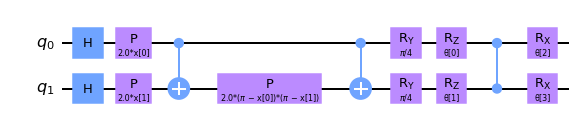

In [62]:
sv = Statevector.from_label('0' * n)
feature_map = ZZFeatureMap(n, reps=1)
var_form = PauliTwoDesign(n, reps=1)
circuit = feature_map.combine(var_form)
circuit.decompose().draw(output='mpl')

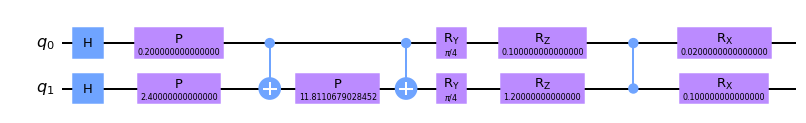

In [63]:
data = [0.1, 1.2]
params = np.array([0.1, 1.2, 0.02, 0.1])
circ_ = circuit.assign_parameters(get_data_dict(params, data))
circ_.decompose().draw(plot_barriers=True)

In [64]:
#Train the classifier
#Training the classifier corresponds to an optimisation task. We want to minimize the cost value
#(sigmoid function) such that the classifier manages to properly label the given data.

# setup the optimizer
optimizer = COBYLA(maxiter=100)
# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True) 
# randomly initialize the parameters
np.random.seed(137)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
# print results
print()
print('opt_params:', opt_params)
print('opt_value: ', value)

0.2962
0.4895
0.4393
0.3202
0.4176
0.3529
0.2877
0.2935
0.2775
0.2699
0.2730
0.2639
0.2692
0.2637
0.2707
0.2571
0.2504
0.2542
0.2532
0.2490
0.2486
0.2519
0.2486
0.2462
0.2445
0.2462
0.2444
0.2434
0.2449
0.2454
0.2427
0.2425
0.2422
0.2425
0.2423
0.2422
0.2423
0.2422
0.2422
0.2422
0.2422
0.2422
0.2422
0.2422
0.2422
0.2422
0.2421
0.2421
0.2421
0.2422
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421
0.2421

opt_params: [5.38643139 0.98601641 4.51576251 4.05766139]
opt_value:  0.2421407655291523


----------------------------------------------------
Data point:  [0.12566371 2.70176968]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7066543454753075, 'B': 0.2933456545246926}
Classification: CORRECT
----------------------------------------------------
Data point:  [1.25663706 5.2150438 ]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.722276716851977, 'B': 0.2777232831480229}
Classification: CORRECT
----------------------------------------------------
Data point:  [4.71238898 4.52389342]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7004361969992465, 'B': 0.2995638030007534}
Classification: CORRECT
----------------------------------------------------
Data point:  [5.2150438  4.46106157]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7384116174601125, 'B': 0.26158838253988753}
Classification: CORRECT
----------------------------------------------------
Data point:  [4.96371639 1.00530965]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7154093381964275, 'B': 0.2845906618035726}
Clas

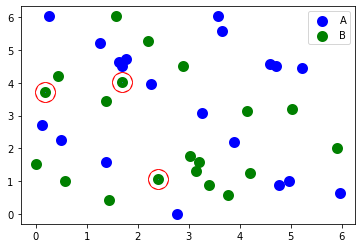

In [73]:
# Test the trained classifier
#To check how well we could train the classifier, we evaluate the classification performance on the
#test data set.
 # collect coordinates of test data
test_label_0_x = [x[0] for x in test_input[class_labels[0]]]
test_label_0_y = [x[1] for x in test_input[class_labels[0]]]
test_label_1_x = [x[0] for x in test_input[class_labels[1]]]
test_label_1_y = [x[1] for x in test_input[class_labels[1]]]
# initialize lists for misclassified datapoints
test_label_misclassified_x = []
test_label_misclassified_y = []
# evaluate test data
for label, samples in test_input.items():
# classify samples
    results = classify(samples, opt_params, class_labels)
# analyze results
    for i, result in enumerate(results):
# assign label
        assigned_label = class_labels[np.argmax([p for p in result.values()])]
        print('----------------------------------------------------')
        print('Data point: ', samples[i])
        print('Label: ', label)
        print('Assigned: ', assigned_label)
        print('Probabilities: ', result)
        if label != assigned_label:
            print('Classification:', 'INCORRECT')
            test_label_misclassified_x += [samples[i][0]]
            test_label_misclassified_y += [samples[i][1]]
        else:
            print('Classification:', 'CORRECT')
# compute fraction of misclassified samples
total = len(test_label_0_x) + len(test_label_1_x)
num_misclassified = len(test_label_misclassified_x)
print()
print(100*(1-num_misclassified/total), "% of the test data was correctly classified!")
# plot results
plt.figure()
plt.scatter(test_label_0_x, test_label_0_y, c='b', label=class_labels[0], linewidths=5)
plt.scatter(test_label_1_x, test_label_1_y, c='g', label=class_labels[1], linewidths=5)
plt.scatter(test_label_misclassified_x, test_label_misclassified_y, linewidths=20, s=1, edgecolors='r')
plt.legend()
plt.show()

## Change optimizer: ADAM

In [68]:
from qiskit.aqua.components.optimizers import ADAM

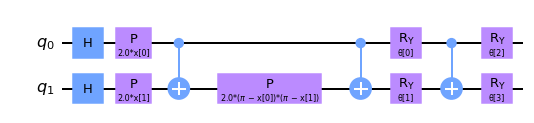

In [69]:
sv = Statevector.from_label('0' * n)
feature_map = ZZFeatureMap(n, reps=1)
var_form = RealAmplitudes(n, reps=1)
circuit = feature_map.combine(var_form)
circuit.decompose().draw(output='mpl')

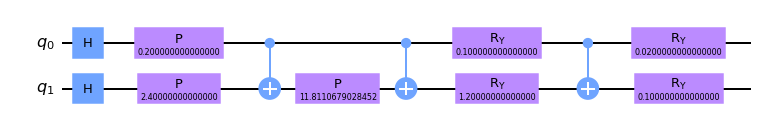

In [70]:
data = [0.1, 1.2]
params = np.array([0.1, 1.2, 0.02, 0.1])
circ_ = circuit.assign_parameters(get_data_dict(params, data))
circ_.decompose().draw(plot_barriers=True)

In [71]:
#Train the classifier
#Training the classifier corresponds to an optimisation task. We want to minimize the cost value
#(sigmoid function) such that the classifier manages to properly label the given data.

# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.05)
# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True) 
# randomly initialize the parameters
np.random.seed(137)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
# print results
print()
print('opt_params:', opt_params)
print('opt_value: ', value)

0.6236
0.6236
0.6236
0.6236
0.6236
0.5986
0.5986
0.5986
0.5986
0.5986
0.5759
0.5759
0.5759
0.5759
0.5759
0.5596
0.5596
0.5596
0.5596
0.5596
0.5496
0.5496
0.5496
0.5496
0.5496
0.5433
0.5433
0.5433
0.5433
0.5433
0.5383
0.5383
0.5383
0.5383
0.5383
0.5331
0.5331
0.5331
0.5331
0.5331
0.5272
0.5272
0.5272
0.5272
0.5272
0.5203
0.5203
0.5203
0.5203
0.5203
0.5124
0.5124
0.5124
0.5124
0.5124
0.5034
0.5034
0.5034
0.5034
0.5034
0.4932
0.4932
0.4932
0.4932
0.4932
0.4818
0.4818
0.4818
0.4818
0.4818
0.4691
0.4691
0.4691
0.4691
0.4691
0.4549
0.4549
0.4549
0.4549
0.4549
0.4389
0.4389
0.4389
0.4389
0.4389
0.4201
0.4201
0.4201
0.4201
0.4201
0.3976
0.3976
0.3976
0.3976
0.3976
0.3714
0.3714
0.3714
0.3714
0.3714
0.3432
0.3432
0.3432
0.3432
0.3432
0.3163
0.3163
0.3163
0.3163
0.3163
0.2933
0.2933
0.2933
0.2933
0.2933
0.2753
0.2753
0.2753
0.2753
0.2753
0.2626
0.2626
0.2626
0.2626
0.2626
0.2543
0.2543
0.2543
0.2543
0.2543
0.2484
0.2484
0.2484
0.2484
0.2484
0.2424
0.2424
0.2424
0.2424
0.2424
0.2341
0.2341
0.2341

----------------------------------------------------
Data point:  [0.12566371 2.70176968]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7066543454753075, 'B': 0.2933456545246926}
Classification: CORRECT
----------------------------------------------------
Data point:  [1.25663706 5.2150438 ]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.722276716851977, 'B': 0.2777232831480229}
Classification: CORRECT
----------------------------------------------------
Data point:  [4.71238898 4.52389342]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7004361969992465, 'B': 0.2995638030007534}
Classification: CORRECT
----------------------------------------------------
Data point:  [5.2150438  4.46106157]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7384116174601125, 'B': 0.26158838253988753}
Classification: CORRECT
----------------------------------------------------
Data point:  [4.96371639 1.00530965]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7154093381964275, 'B': 0.2845906618035726}
Clas

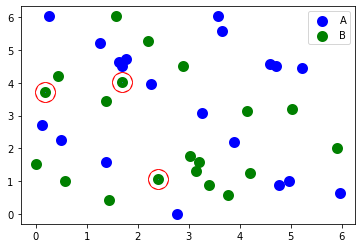

In [72]:
# Test the trained classifier
#To check how well we could train the classifier, we evaluate the classification performance on the
#test data set.
 # collect coordinates of test data
test_label_0_x = [x[0] for x in test_input[class_labels[0]]]
test_label_0_y = [x[1] for x in test_input[class_labels[0]]]
test_label_1_x = [x[0] for x in test_input[class_labels[1]]]
test_label_1_y = [x[1] for x in test_input[class_labels[1]]]
# initialize lists for misclassified datapoints
test_label_misclassified_x = []
test_label_misclassified_y = []
# evaluate test data
for label, samples in test_input.items():
# classify samples
    results = classify(samples, opt_params, class_labels)
# analyze results
    for i, result in enumerate(results):
# assign label
        assigned_label = class_labels[np.argmax([p for p in result.values()])]
        print('----------------------------------------------------')
        print('Data point: ', samples[i])
        print('Label: ', label)
        print('Assigned: ', assigned_label)
        print('Probabilities: ', result)
        if label != assigned_label:
            print('Classification:', 'INCORRECT')
            test_label_misclassified_x += [samples[i][0]]
            test_label_misclassified_y += [samples[i][1]]
        else:
            print('Classification:', 'CORRECT')
# compute fraction of misclassified samples
total = len(test_label_0_x) + len(test_label_1_x)
num_misclassified = len(test_label_misclassified_x)
print()
print(100*(1-num_misclassified/total), "% of the test data was correctly classified!")
# plot results
plt.figure()
plt.scatter(test_label_0_x, test_label_0_y, c='b', label=class_labels[0], linewidths=5)
plt.scatter(test_label_1_x, test_label_1_y, c='g', label=class_labels[1], linewidths=5)
plt.scatter(test_label_misclassified_x, test_label_misclassified_y, linewidths=20, s=1, edgecolors='r')
plt.legend()
plt.show()